In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')


## The data here is ↓↓↓ collected by the best hyperparamters set, and I accidentally repeating runing 10 times instead of 5 times(Mentioned in the task requirement). But I do not think this is a problem. 

In [50]:
# Load the CSV files
mu_plus_df = pd.read_csv('mu_plus_lambda_metrics.csv')
mu_comma_df = pd.read_csv('mu_comma_lambda_metrics.csv')

### - AVG of Fitness_avg vs. Generations for $(\mu + \lambda)$ EA and $(\mu, \lambda)$ EA of various enemies

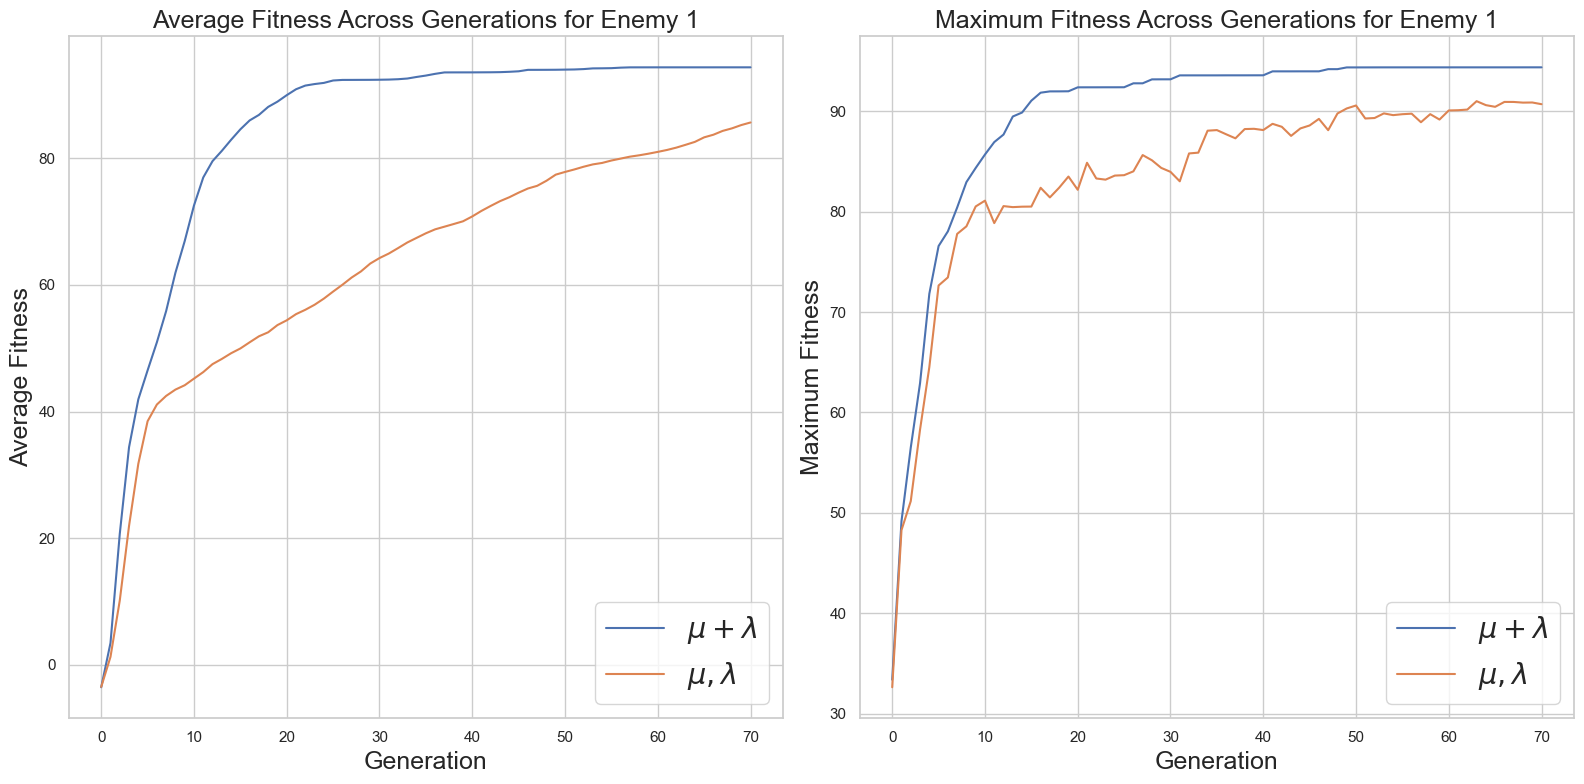

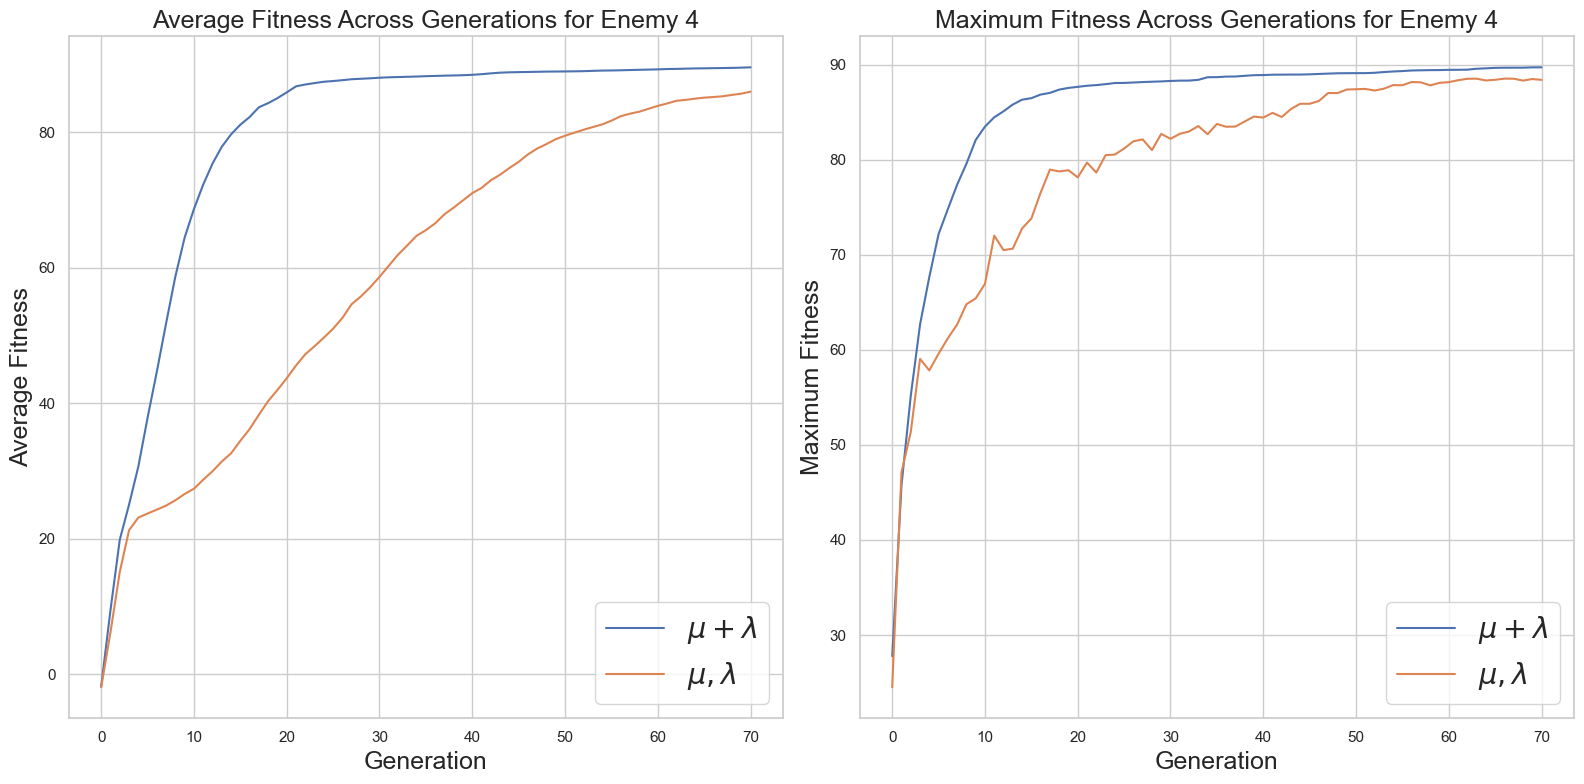

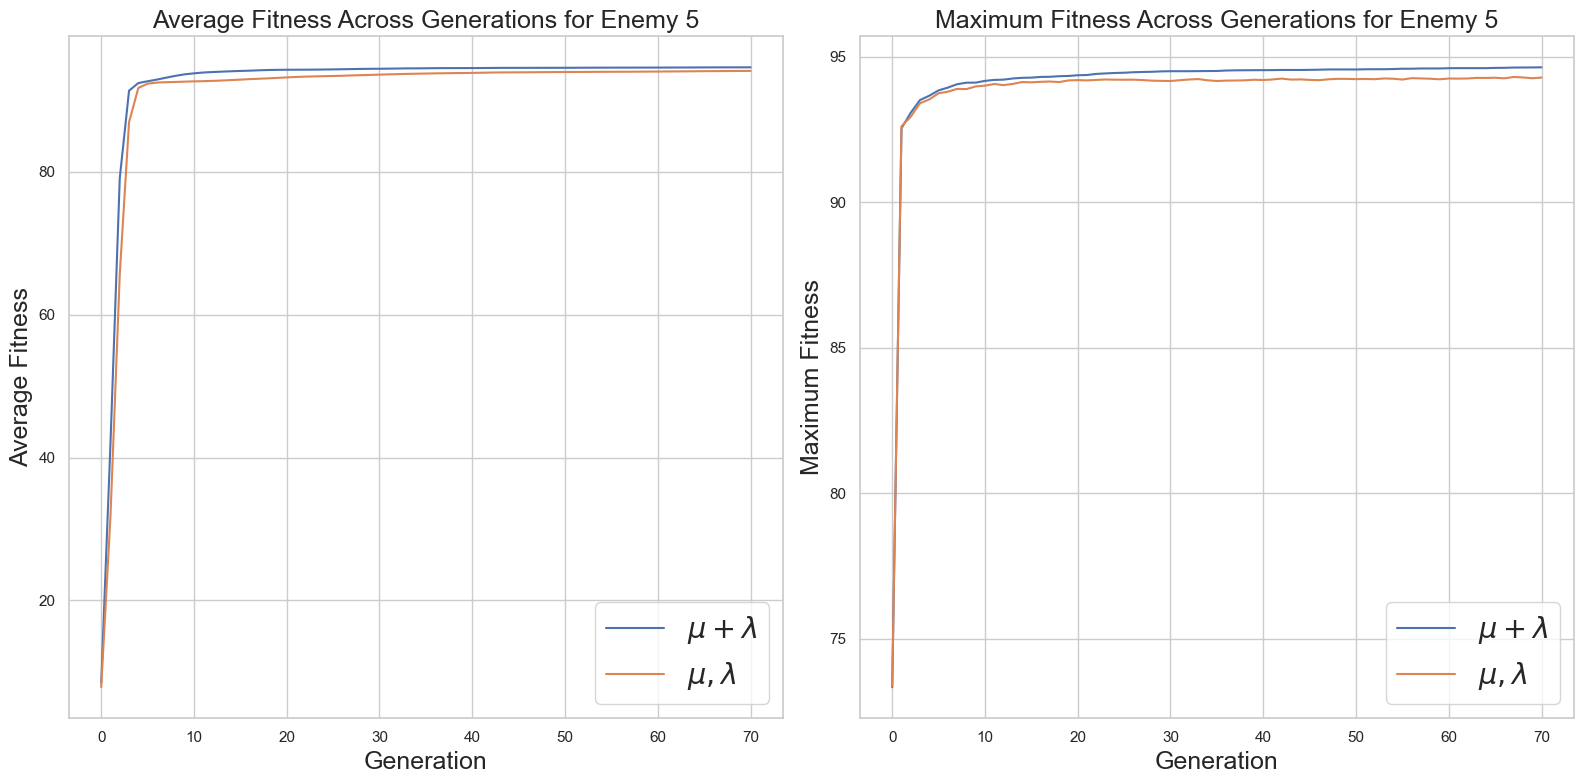

In [51]:
mu_plus_df['Algorithm'] = f'$\mu + \lambda$'
mu_comma_df['Algorithm'] = f'$\mu , \lambda$'

combined_df = pd.concat([mu_plus_df, mu_comma_df])

# Group by 'Enemy', 'Generation', and 'Algorithm', then calculate the mean and standard deviation
grouped_df = combined_df.groupby(['Enemy', 'Generation', 'Algorithm']).agg({
    'Fitness_Avg': ['mean', 'std'],
    'Fitness_Max': ['mean', 'std']
}).reset_index()

# Flatten the MultiIndex for easier plotting
grouped_df.columns = ['_'.join(col).strip() for col in grouped_df.columns.values]
grouped_df.rename(columns={'Enemy_': 'Enemy', 'Generation_': 'Generation', 'Algorithm_': 'Algorithm'}, inplace=True)

enemies = grouped_df['Enemy'].unique()
for enemy in enemies:
    enemy_data = grouped_df[grouped_df['Enemy'] == enemy]
    
    plt.figure(figsize=(16, 8))
    
    # Plot for average fitness
    plt.subplot(1, 2, 1)
    sns.lineplot(x='Generation', y='Fitness_Avg_mean', hue='Algorithm', data=enemy_data, style='Algorithm', markers=False, dashes=False)
    plt.title(f'Average Fitness Across Generations for Enemy {enemy}', fontsize=18)
    plt.xlabel('Generation', fontsize=18)
    plt.ylabel('Average Fitness', fontsize=18)
    plt.legend(loc = 'lower right', fontsize= 'xx-large')
    
    # Plot for maximum fitness
    plt.subplot(1, 2, 2)
    sns.lineplot(x='Generation', y='Fitness_Max_mean', hue='Algorithm', data=enemy_data, style='Algorithm', markers=False, dashes=False)
    plt.title(f'Maximum Fitness Across Generations for Enemy {enemy}', fontsize=18)
    plt.xlabel('Generation', fontsize=18)
    plt.ylabel('Maximum Fitness', fontsize=18)

    plt.legend(loc = 'lower right', fontsize= 'xx-large')
    plt.tight_layout()
    plt.show()


### - Comparing the Individual Gain of $(\mu + \lambda)$ EA and $(\mu, \lambda)$ EA of various enemies in Boxplots

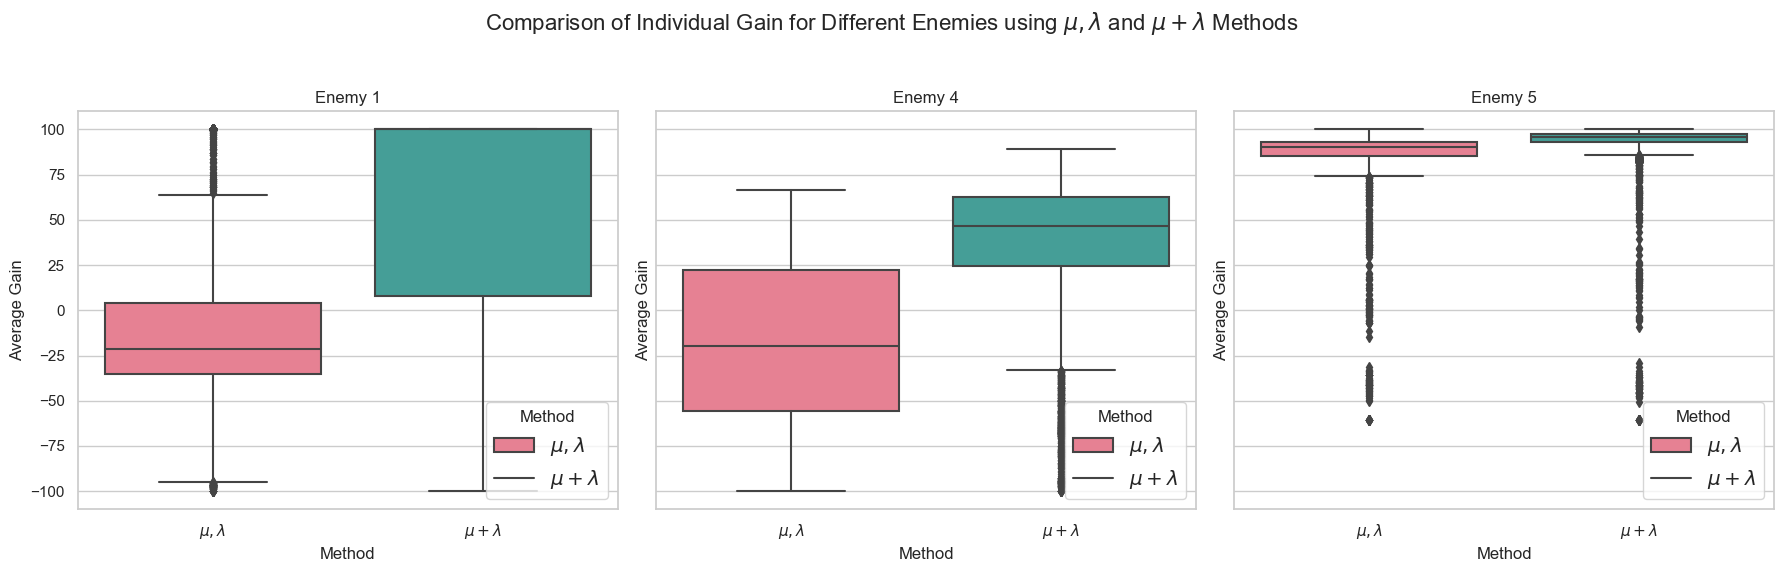

In [52]:
# Filter the data for Gain_Avg and Enemy
mu_comma_lambda_filtered = mu_comma_df[['Enemy', 'Gain_Avg']]
mu_plus_lambda_filtered = mu_plus_df[['Enemy', 'Gain_Avg']]

# Add a new column to indicate the method
mu_comma_lambda_filtered['Method'] = r'$\mu, \lambda$'
mu_plus_lambda_filtered['Method'] = r'$\mu + \lambda$'

# Concatenate the two dataframes
combined_df = pd.concat([mu_comma_lambda_filtered, mu_plus_lambda_filtered])

# Create separate box plots for each enemy
unique_enemies = combined_df['Enemy'].unique()
fig, axes = plt.subplots(1, len(unique_enemies), figsize=(18, 6), sharey=True)

# Customize the plots for better visibility
sns.set(style="whitegrid")
palette = sns.color_palette("husl", 2)

# Loop through each unique enemy and create a box plot
for i, enemy in enumerate(unique_enemies):
    ax = axes[i]
    sns.boxplot(x='Method', y='Gain_Avg', data=combined_df[combined_df['Enemy'] == enemy], ax=ax, palette=palette)
    ax.set_title(rf'Enemy {enemy}')
    ax.set_xlabel('Method')
    ax.set_ylabel('Average Gain')
    ax.legend(title='Method', labels=[r'$\mu, \lambda$', r'$\mu + \lambda$'], loc='lower right', fontsize= 'large')
# Add a main title for all subplots
fig.suptitle(r'Comparison of Individual Gain for Different Enemies using $\mu, \lambda$ and $\mu + \lambda$ Methods', fontsize=16)



plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### - Verify if the differences in the average of these means are significant between the groups of best solutions, when comparing two algorithms of an enemy

In [55]:

grouped_mu_plus = mu_plus_df.groupby(['Enemy', 'Simulation'])['Gain_Avg'].mean().reset_index()
grouped_mu_comma = mu_comma_df.groupby(['Enemy', 'Simulation'])['Gain_Avg'].mean().reset_index()


enemies = grouped_mu_plus['Enemy'].unique()  
for enemy in enemies:
    # Filter the data for the current enemy
    data_mu_plus = grouped_mu_plus[grouped_mu_plus['Enemy'] == enemy]['Gain_Avg']
    data_mu_comma = grouped_mu_comma[grouped_mu_comma['Enemy'] == enemy]['Gain_Avg']
    
    # Perform the t-test
    t_stat, p_val = ttest_ind(data_mu_plus, data_mu_comma)
    
    print(f"For Enemy {enemy}, T-statistic: {t_stat}, P-value: {p_val}")


For Enemy 1, T-statistic: 13.637377973747299, P-value: 6.272743668305368e-11
For Enemy 4, T-statistic: 20.399943778321706, P-value: 6.841636570029351e-14
For Enemy 5, T-statistic: 19.630550298306396, P-value: 1.3286502791392117e-13


### Now, like before, These are plots shows the impact of initial diversity of population on converegnce of "fitness_avg"

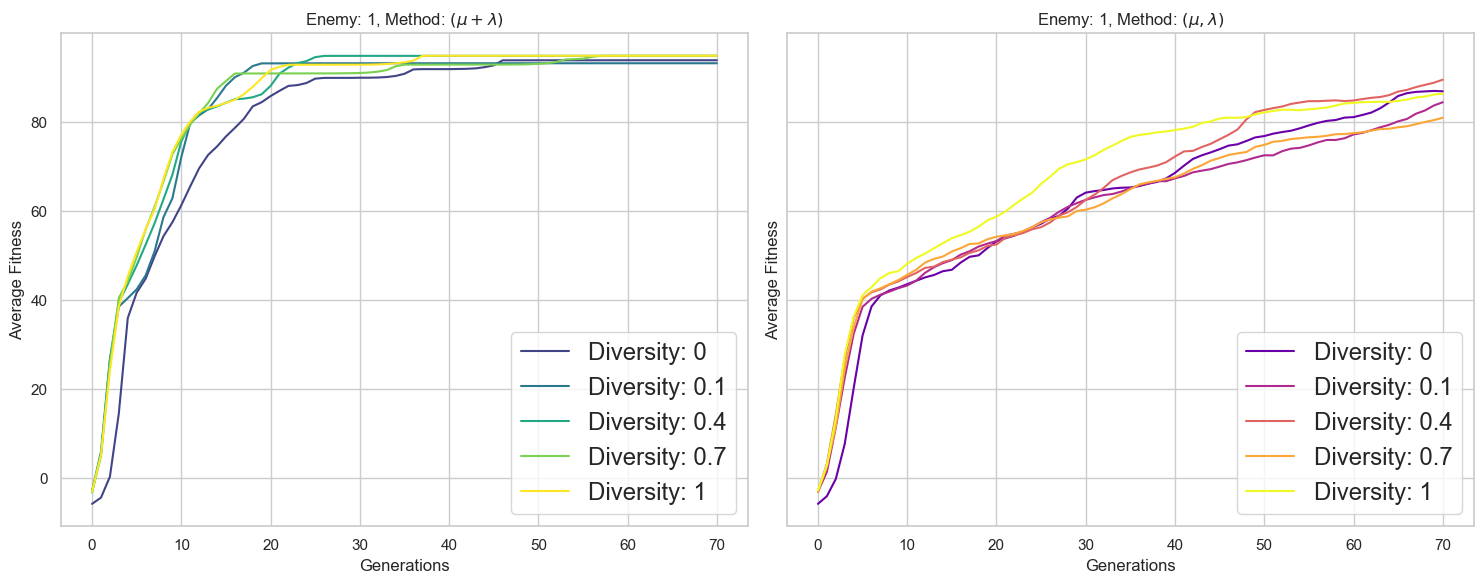

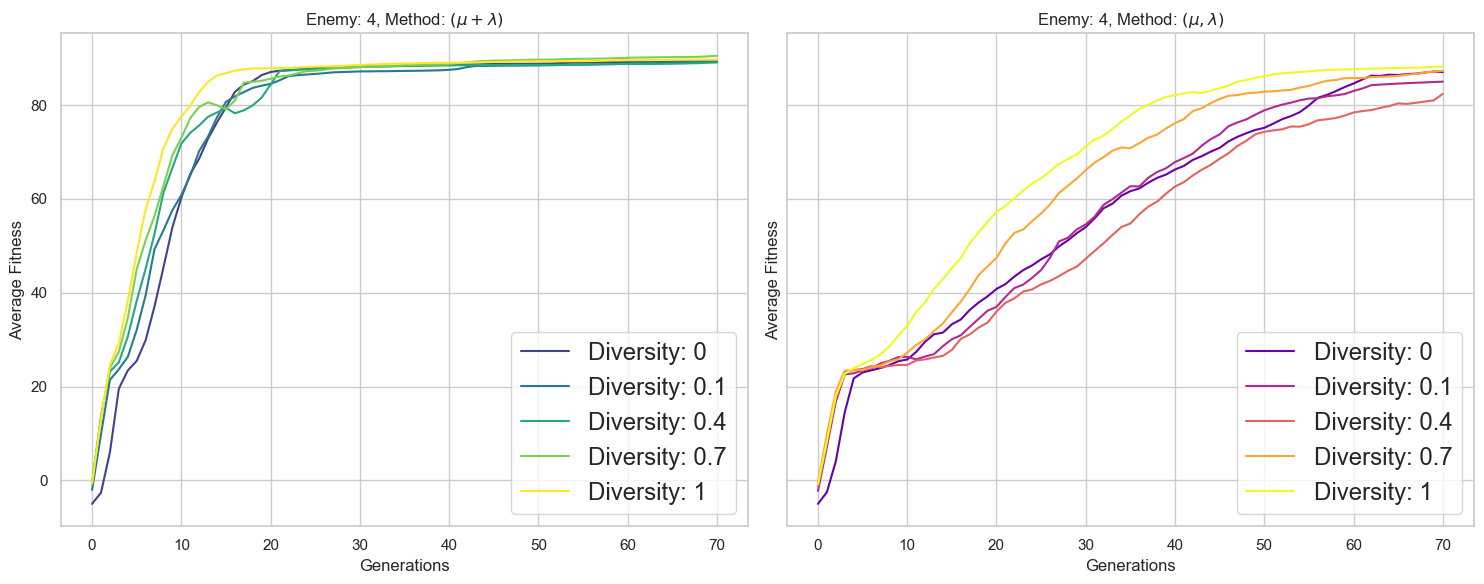

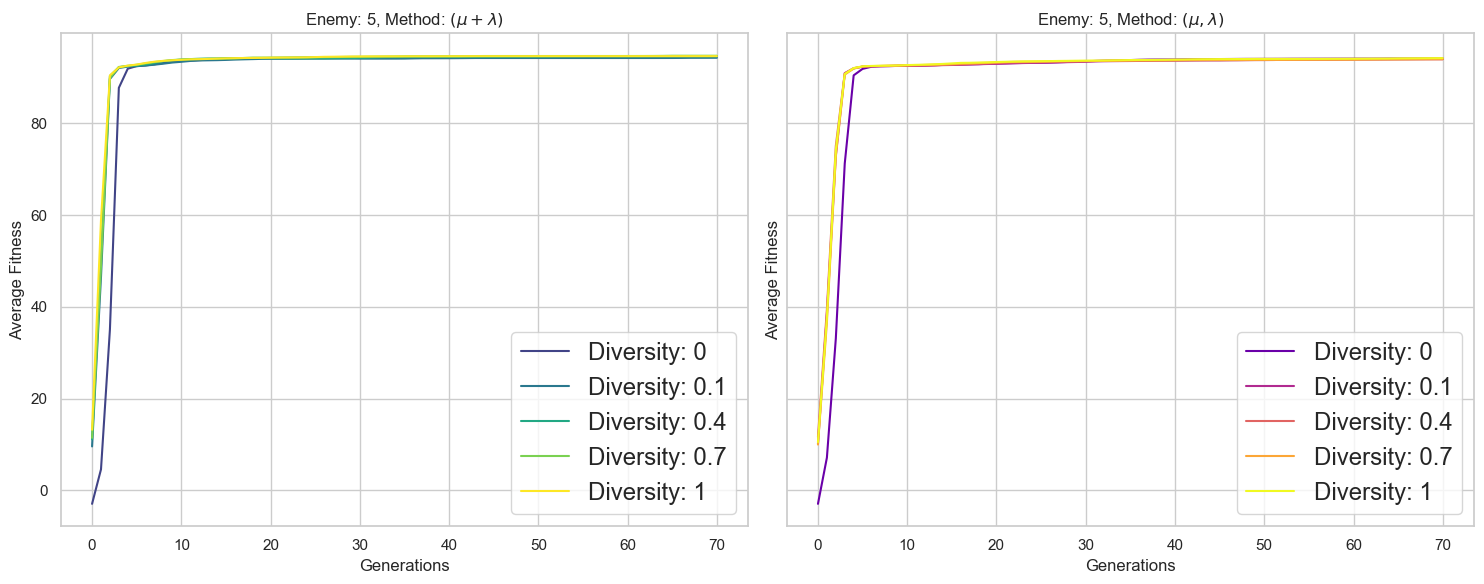

In [29]:
# Initialize color maps for each EA method
cmap_plus = plt.cm.get_cmap('viridis')
cmap_comma = plt.cm.get_cmap('plasma')

diversity_levels = [0, 0.1 , 0.4 ,0.7, 1]
enemies = [1, 4, 5] 

for enemy in enemies:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
    for i, diversity in enumerate(diversity_levels):
        # Generate a color from the color map
        color_plus = cmap_plus((i + 1) / len(diversity_levels))
        color_comma = cmap_comma((i + 1) / len(diversity_levels))
        
        # Filter data for each enemy and diversity level
        filter_plus = (mu_plus_df['Enemy'] == enemy) & (mu_plus_df['Initial_Diversity'] == diversity)
        filter_comma = (mu_comma_df['Enemy'] == enemy) & (mu_comma_df['Initial_Diversity'] == diversity)
        
        # Calculate the means across all runs
        mean_mu_plus = mu_plus_df[filter_plus].groupby('Generation')['Fitness_Avg'].mean()
        mean_mu_comma = mu_comma_df[filter_comma].groupby('Generation')['Fitness_Avg'].mean()
        
        # Plotting for mu + lambda
        axes[0].plot(mean_mu_plus, label=f'Diversity: {diversity}', color=color_plus)
        
        # Plotting for mu, lambda
        axes[1].plot(mean_mu_comma, label=f'Diversity: {diversity}', color=color_comma)
        
    axes[0].set_title(f'Enemy: {enemy}, Method: $(\mu + \lambda)$')
    axes[1].set_title(f'Enemy: {enemy}, Method: $(\mu, \lambda)$')
    
    for ax in axes:
        ax.set_xlabel('Generations')
        ax.set_ylabel('Average Fitness')
        ax.legend(loc='lower right', fontsize='x-large')  
    
    plt.tight_layout()
    plt.show()


### These are plots shows the impact of initial diversity of population on converegnce of "fitness_max"

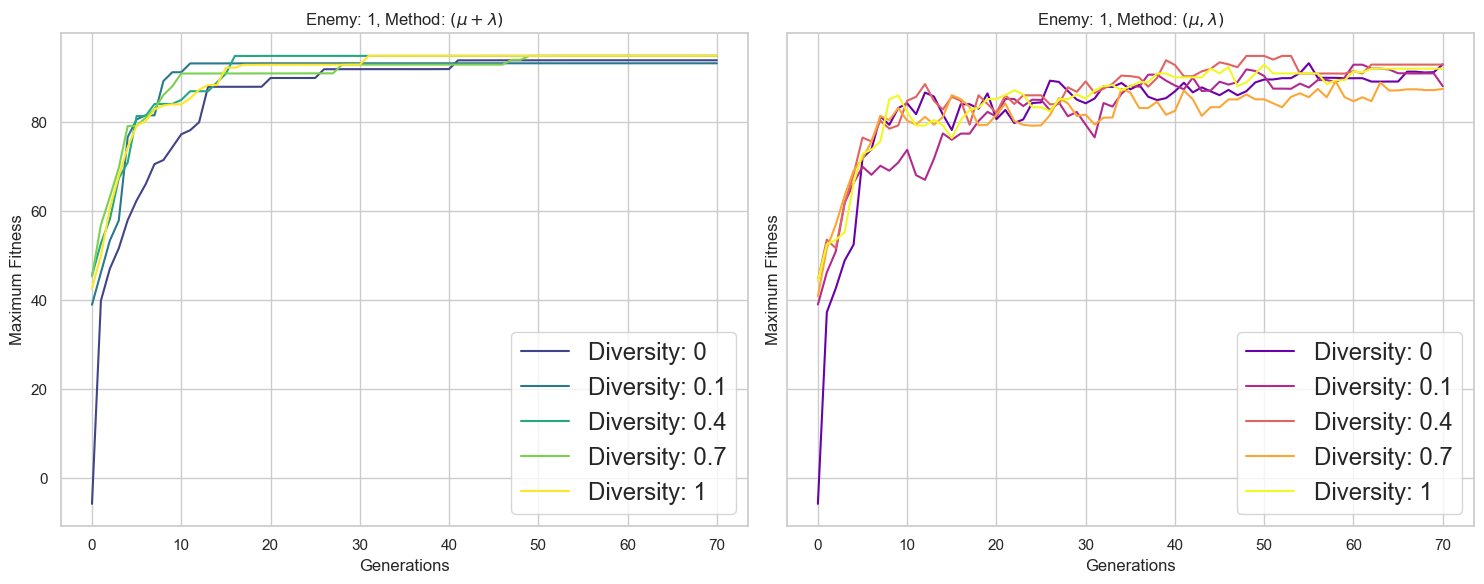

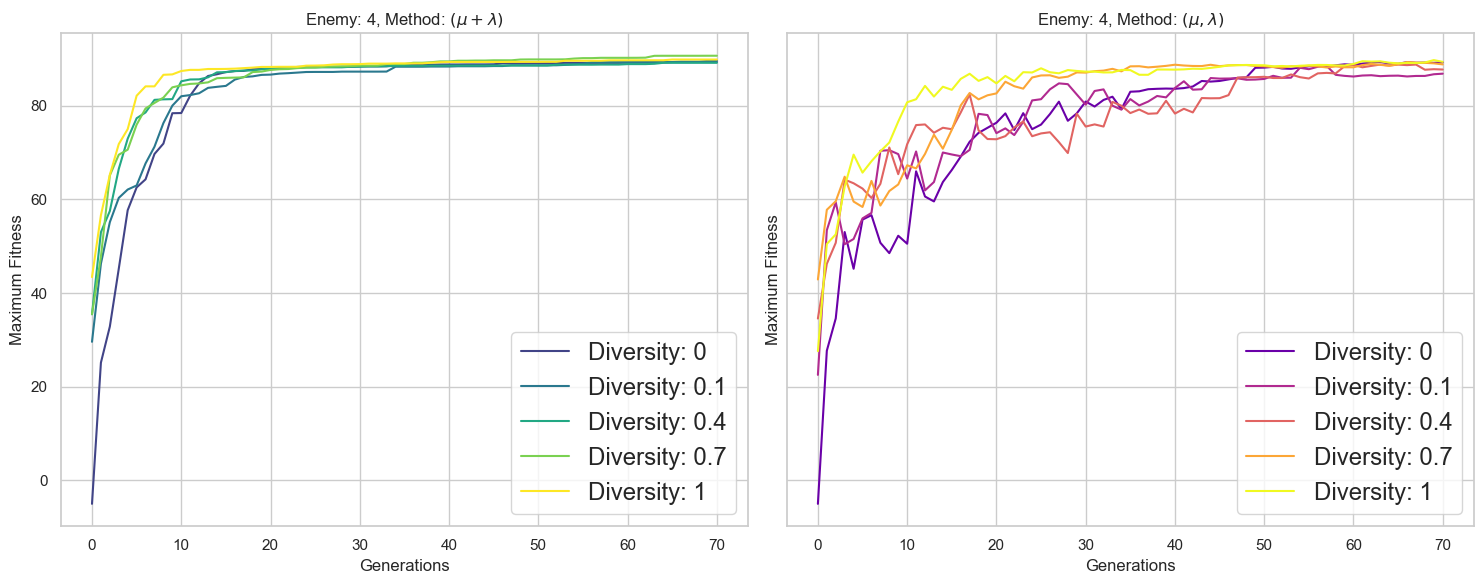

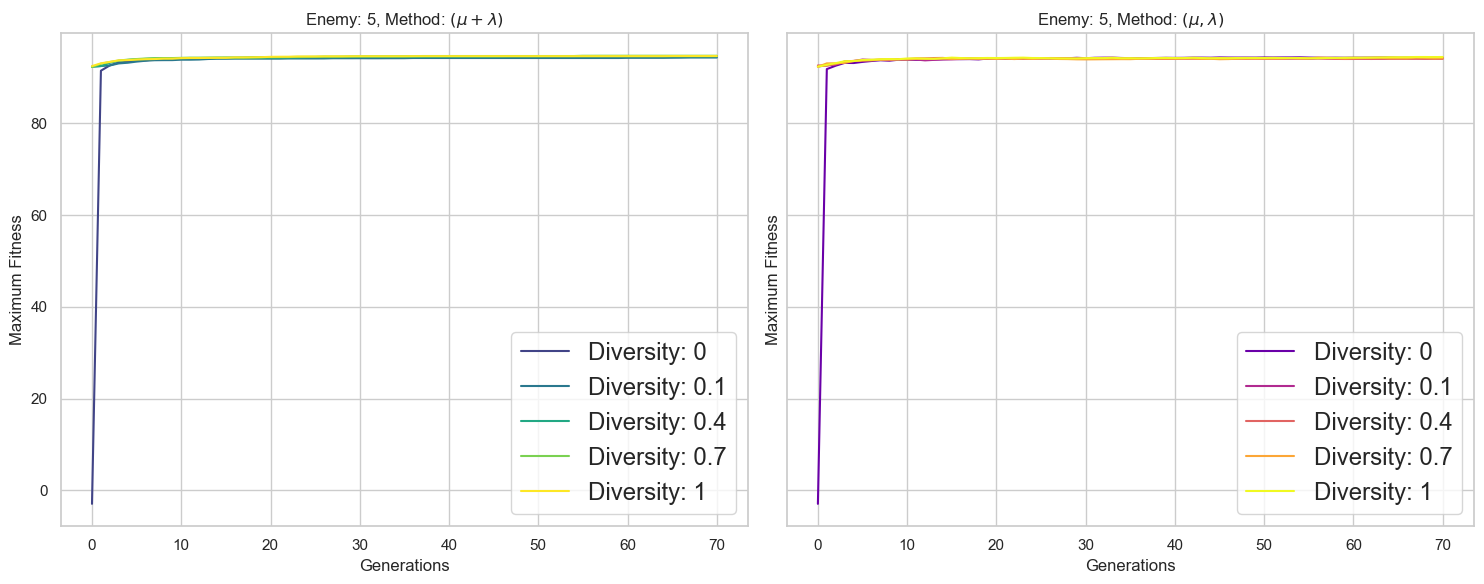

In [31]:
for enemy in enemies:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
    for i, diversity in enumerate(diversity_levels):
        # Generate a color from the color map
        color_plus = cmap_plus((i + 1) / len(diversity_levels))
        color_comma = cmap_comma((i + 1) / len(diversity_levels))
        
        # Filter data for each enemy and diversity level
        filter_plus = (mu_plus_df['Enemy'] == enemy) & (mu_plus_df['Initial_Diversity'] == diversity)
        filter_comma = (mu_comma_df['Enemy'] == enemy) & (mu_comma_df['Initial_Diversity'] == diversity)
        
        # Calculate the means across all runs
        mean_mu_plus = mu_plus_df[filter_plus].groupby('Generation')['Fitness_Max'].mean()
        mean_mu_comma = mu_comma_df[filter_comma].groupby('Generation')['Fitness_Max'].mean()
        
        # Plotting for mu + lambda
        axes[0].plot(mean_mu_plus, label=f'Diversity: {diversity}', color=color_plus)
        
        # Plotting for mu, lambda
        axes[1].plot(mean_mu_comma, label=f'Diversity: {diversity}', color=color_comma)
        
    axes[0].set_title(f'Enemy: {enemy}, Method: $(\mu + \lambda)$')
    axes[1].set_title(f'Enemy: {enemy}, Method: $(\mu, \lambda)$')
    
    for ax in axes:
        ax.set_xlabel('Generations')
        ax.set_ylabel('Maximum Fitness')
        ax.legend(loc='lower right', fontsize='x-large')  
    
    plt.tight_layout()
    plt.show()

### Boxplots of the "Fitness_avg" vs Initial diversity for $(\mu + \lambda)$ EA and $(\mu, \lambda)$ EA of various enemies

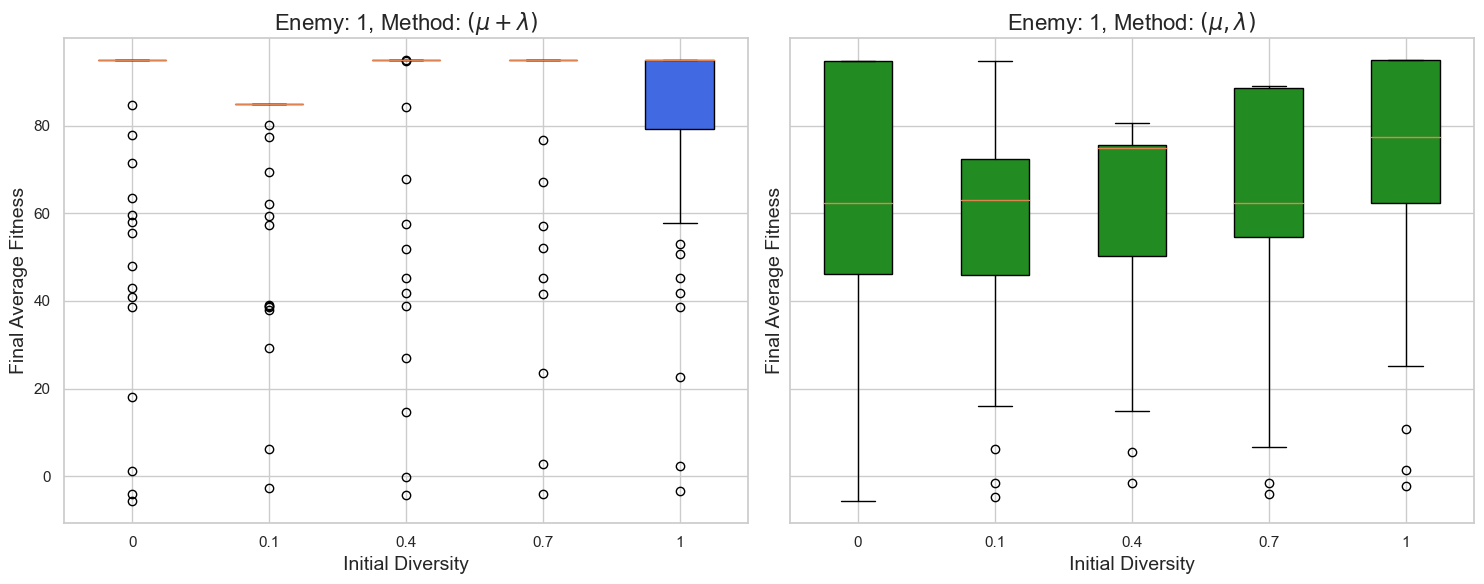

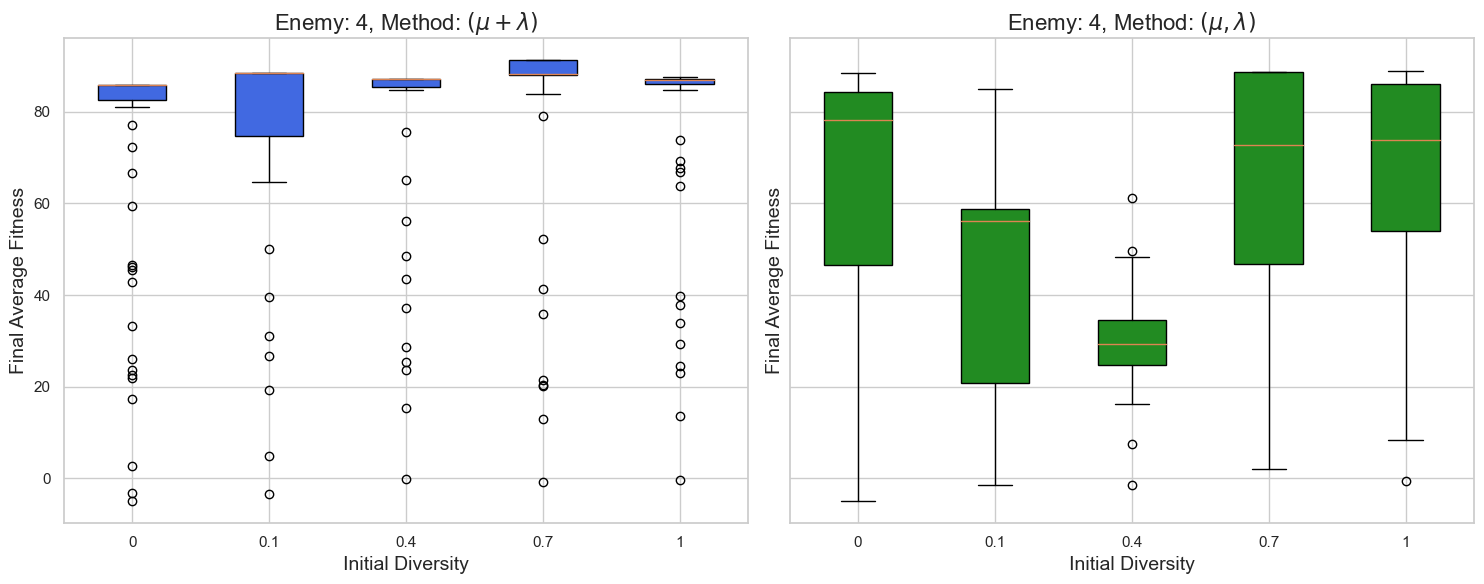

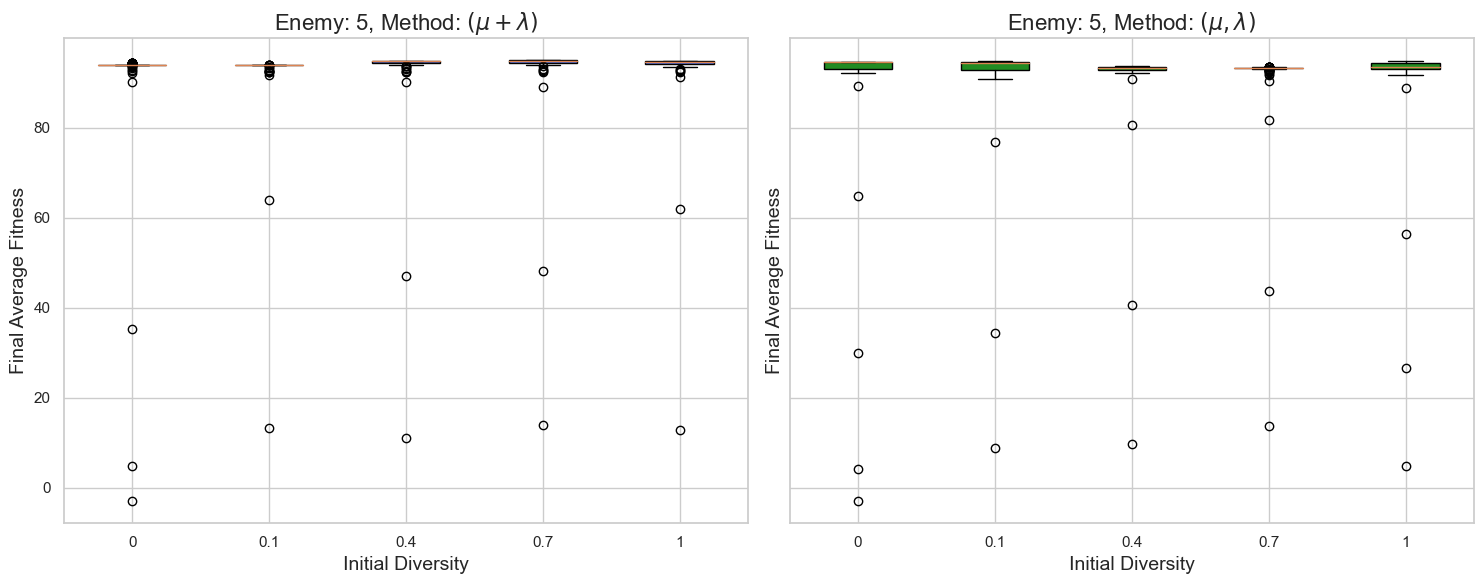

In [38]:
diversity_levels = [0, 0.1 , 0.4 ,0.7, 1]
enemies = [1, 4, 5]

for enemy in enemies:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
    final_fitness_plus = []
    final_fitness_comma = []
    
    for i, diversity in enumerate(diversity_levels):
        
        # Filter data for each enemy and diversity level
        filter_plus = (mu_plus_df['Enemy'] == enemy) & (mu_plus_df['Initial_Diversity'] == diversity)
        filter_comma = (mu_comma_df['Enemy'] == enemy) & (mu_comma_df['Initial_Diversity'] == diversity)
        
        # Get the final generation fitness average for all runs
        final_gen_fitness_plus = mu_plus_df[filter_plus].groupby('Generation')['Fitness_Avg'].last().values
        final_gen_fitness_comma = mu_comma_df[filter_comma].groupby('Generation')['Fitness_Avg'].last().values
        
        final_fitness_plus.append(final_gen_fitness_plus)
        final_fitness_comma.append(final_gen_fitness_comma)
        
    # Plotting for mu + lambda
    axes[0].boxplot(final_fitness_plus, patch_artist=True, labels=[str(d) for d in diversity_levels], boxprops=dict(facecolor='royalblue'))
    axes[0].set_title(f'Enemy: {enemy}, Method: $(\\mu + \\lambda)$', fontsize=16)
    
    # Plotting for mu, lambda
    axes[1].boxplot(final_fitness_comma, patch_artist=True, labels=[str(d) for d in diversity_levels], boxprops=dict(facecolor='forestgreen'))
    axes[1].set_title(f'Enemy: {enemy}, Method: $(\\mu, \\lambda)$', fontsize=16)
    
    for ax in axes:
        ax.set_xlabel('Initial Diversity', fontsize=14)
        ax.set_ylabel('Final Average Fitness', fontsize=14)
    
    plt.tight_layout()
    plt.show()


### Boxplots of the "Fitness_max" vs Initial diversity for $(\mu + \lambda)$ EA and $(\mu, \lambda)$ EA of various enemies

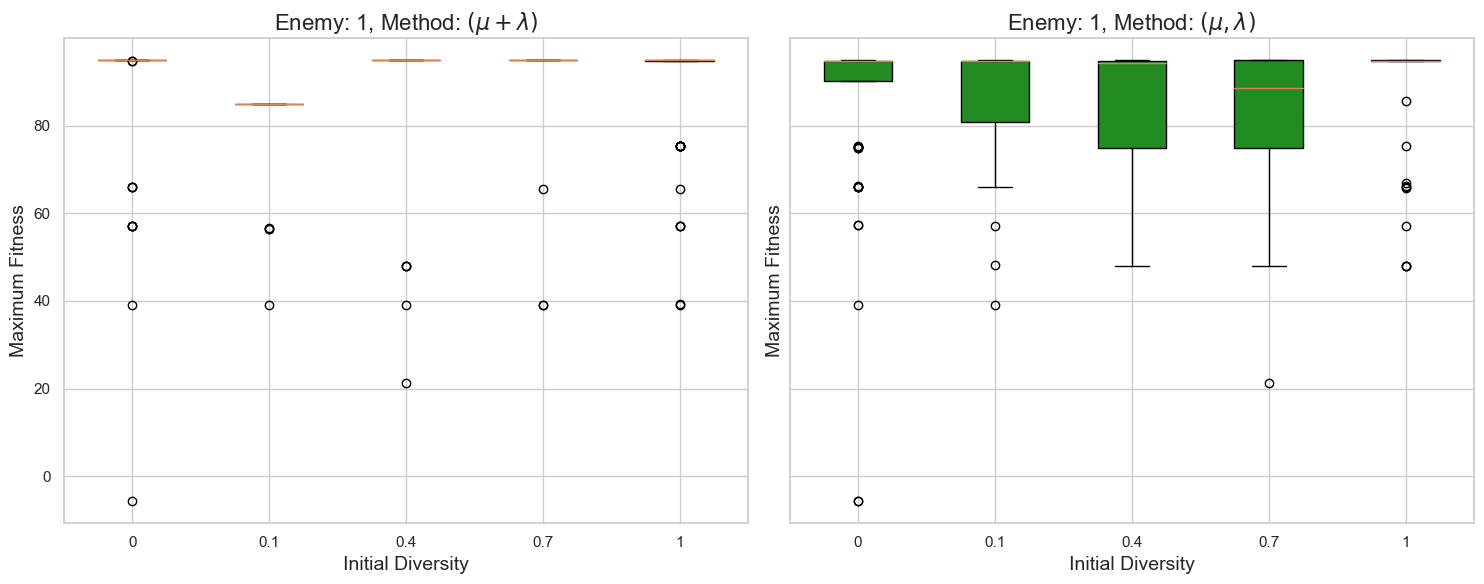

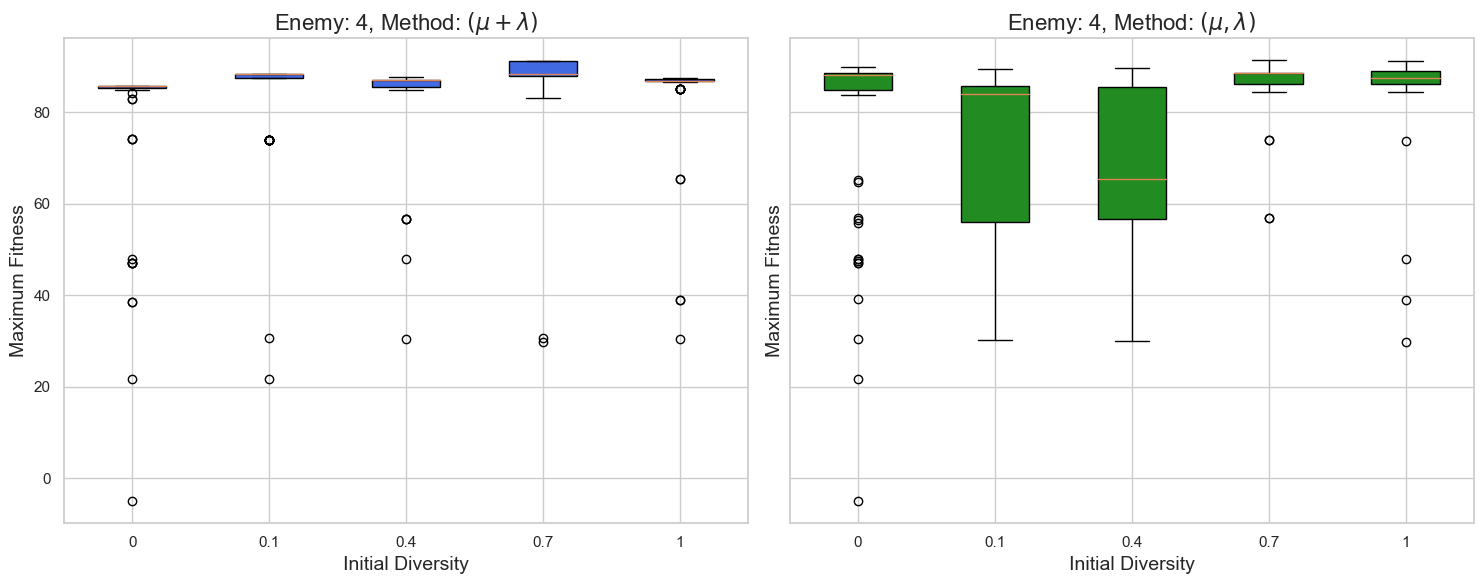

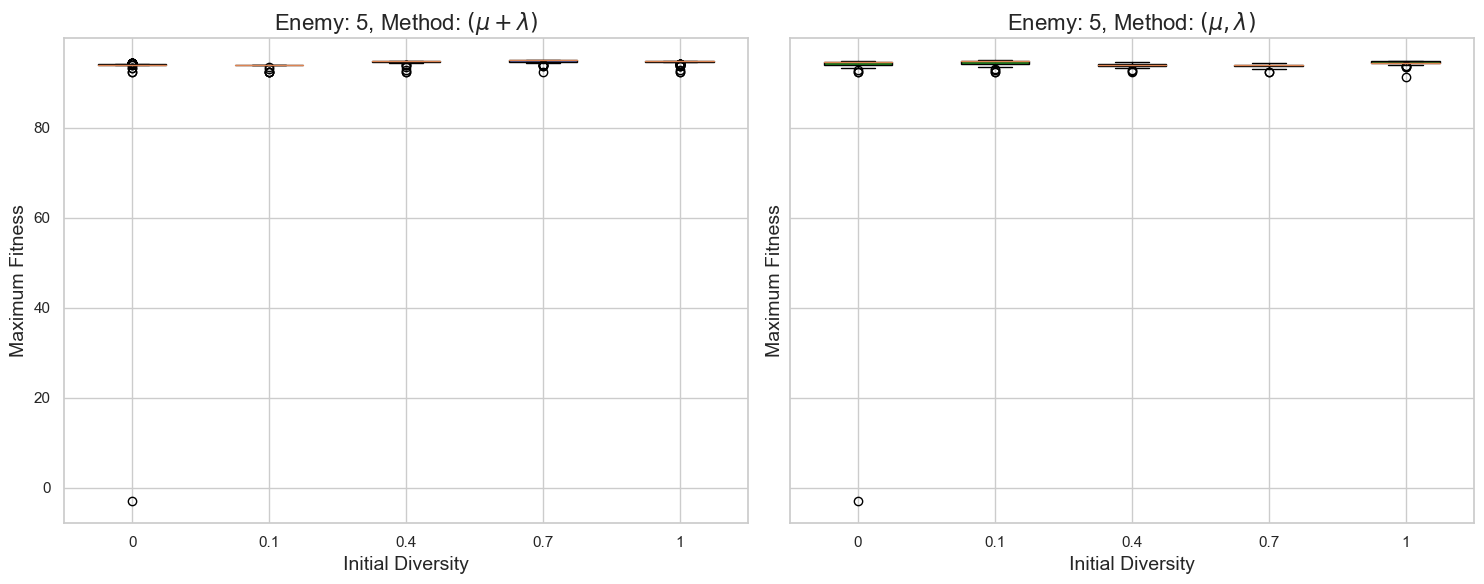

In [39]:

diversity_levels = [0, 0.1 , 0.4 ,0.7, 1]
enemies = [1, 4, 5]

for enemy in enemies:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
    final_fitness_plus = []
    final_fitness_comma = []
    
    for i, diversity in enumerate(diversity_levels):
        
        # Filter data for each enemy and diversity level
        filter_plus = (mu_plus_df['Enemy'] == enemy) & (mu_plus_df['Initial_Diversity'] == diversity)
        filter_comma = (mu_comma_df['Enemy'] == enemy) & (mu_comma_df['Initial_Diversity'] == diversity)
        
        # Get the final generation fitness average for all runs
        final_gen_fitness_plus = mu_plus_df[filter_plus].groupby('Generation')['Fitness_Max'].last().values
        final_gen_fitness_comma = mu_comma_df[filter_comma].groupby('Generation')['Fitness_Max'].last().values
        
        final_fitness_plus.append(final_gen_fitness_plus)
        final_fitness_comma.append(final_gen_fitness_comma)
        
    # Plotting for mu + lambda
    axes[0].boxplot(final_fitness_plus, patch_artist=True, labels=[str(d) for d in diversity_levels], boxprops=dict(facecolor='royalblue'))
    axes[0].set_title(f'Enemy: {enemy}, Method: $(\\mu + \\lambda)$', fontsize=16)
    
    # Plotting for mu, lambda
    axes[1].boxplot(final_fitness_comma, patch_artist=True, labels=[str(d) for d in diversity_levels], boxprops=dict(facecolor='forestgreen'))
    axes[1].set_title(f'Enemy: {enemy}, Method: $(\\mu, \\lambda)$', fontsize=16)
    
    for ax in axes:
        ax.set_xlabel('Initial Diversity', fontsize=14)
        ax.set_ylabel('Maximum Fitness', fontsize=14)
    
    plt.tight_layout()
    plt.show()
